# Observation-level MSTs for Machine-Assisted Edge Annotation

Key issue when we want to communicate to a computer "how data are related", is the network analysis "hairball". 
This is especially true when we desire some form of learned representation in the feature space (extracted taxonomy, community detection, hierarchical clustering), since such tasks generally deal with dense networks formed from thousands of co-occurrence observations, and the underlying "structure" to be learned is generally very sparse, often tree-like. 
The goal is to find edges in the network that are critical to the domain in question (sometimes called the network's "backbone" edges), while filtering (or "backboning") the rest of the edges to avoid overwhelming annotators. 

An "indirect" approach to solving this annotation issue is through "supervised learning", sometimes extended to collaborative filtering, where a user or users manually annotate some subset of the data and a machine-learning system attempts to "predict" annotations for the remainder. 
This has issues with scalability, since a large fraction of single-or-multi-labeled observation targets need to exist before accuracy improves, which generally defeats the purpose of these ad hoc information architecture design assistants, in the first place. 
We would rather have a pre-filtered (or, at a minimum, _ranked_) view of the network edges to provide a guided approach to labeling in the _first place_. 

A-priori filtering of edges to enable more focused network analysis is a common technique to deal with spurrious relationships in social network analysis, text keyword discovery, and recommender systems. 
The goal is to preprocess a given network graph in a way that we are left with the "backbone" of the "hairball" we were initial given. 
A recent surge in interest has led to a number of techniques with varying properties. 
These are an excellent starting point, and often require only minimal computational overhead for drastically improved ergonomics. 

However, all backboning algorithms we have found in the literature to-date frame a graph-style dataset as given, _a priori_, such that the network is used to discover interractions, rather than for the purpose of annotating important relationships in the domain. 
In our case, we need an _iterative_ system that can backbone networks through incorporating what _gave rise to_ the network --- the observational data itself. 
Then, it should be able to incorporate annotations from a domain expert in an _online_ fashion, improving the suggestions of future relationships as the annotator progresses through the "backbone" edgewise.  



## What can we do about this? 

To better address the "hairball", and understand its origin, it helps to recognize how often problematic "networks" are in fact bipartite projections from an _observed incidence structure_.
(see grabble)

### Incidene Structure Projections
Graphs like the co-authorship, Enron correspondence, and `delic.io.us` tag networks are all forms of _co-occurrence graphs_, where two entities viewed as "vertices" (authors, employees, tags) co-occur via (i.e. are incident-to) another entity type within the original dataset (papers, emails, bookmarks). 
These _incidence structures_ are a more general form of a bipartite graph (kinda... bipartite graphs can be viewed as a Levi graph of an equivalent incidence structure) between the two entity types, and it's through _bipartite projection_ that we arrive at the networks we know and love. 
For instane, a document-term matrix from NLP can be seen as a bipartite graph between documents, which can be projected into a network of term similarities, using documents ("edges") as a co-occurrence structure for terms (as "nodes"). 

By using this insight we can treat the given graph as an incidence structure arising from the use of the original data as a Levi graph. 
This let's us backbone the graph of interest through filtering the levi graph directly. 
There are two main points to achieving this: Observation-level MSTs, and subgraph MST stability through application of graph heat kernels. 

### MST Backboning
the bipartite projection can be re-weighted to include only the minimum necessary edges that each observation requires to exist (kinda like occams razor). 
  We use a Minimum Spanning Tree (MST) on the original k-clique implied by traditional (linear) bipartite projection. 
  NOTE: these MSTs are calculated on a per-subgraph basis...With an original noisy graph $G=(V,E)$ (where E is linearly projected from the incidence structure $(V, O, I\subset{\{V\times O\}})$), then we say if the subgraph $S_i(G)$ is induced by observation $O_i\in O$ (i.e. S_i is the bipartite projection of the structure $(V,O_i, I\subset{\{V\times O_i\}})$, we define our backbone of G as 
  $$\hat{G}=\bigcup_{i}MST(S_i(G))$$
  where we use the non-disjoint union of graphs, $G_1 \cup G_2 = (V_1\cup V_2, E_1\cup E_2)$

### Addressing MST Stability 
Despite its efficiency, especially for the relatively small node-set that each subgraph will contain relative to the entire graph, MSTs are very unstable to noise in edges (both their existence and their "weight").
Small perturbations in $E$ can drastically shift the resulting $MST(S_i)$, and although we expect a "smoothing" to occur in the union over large $\|O\|$, a reduced need for "big data" was one of our initial needs in choosing a backbone-workflow over a supervised learning one. 
It is also fundamentally problematic to have non-smooth $S_i$ when this is the _core way_ we propose humans to interact with the dataset (unstable filtering on $O_i$ leads to trust reduction, etc.). 
For example, if edges are filtered as a way to better suggest relationships for an expert to _annotate_, and that annotation causes erratic behavior of the MSTs at every iteration, then the human can never build a reliable mental model of how exactly continued interaction with the machine system will benefit the annotation process. 
after all, recall that edge "noise", from our incidence-structure frame-of-reference, arises from new or altered observations $O_i$ that get "projected"...i.e. new or changed _data_). 

It was discovered (REF) that MST's can be made more stable to noise like edge addition and alteration if the MST is calculated on a smooth, metric-based approximation of distances on the original graph. 
One way to do this, seen in XXXX, is to caclulate the MST on the graph induced by using the Commute-time Kernel $L^+$, where $L$ is the graph Laplacian and $A^+$ is the Moore-Penrose pseudoinverse of matrix $A$ (since L is not strictly invertible). 

this alters our original backbone to take the form: 
$$\hat{G}=\bigcup_{i}MST(S_i(L^+))$$

A similar idea applies to using the Doubly-Stochastic re-weighting of our graph, $DS(G)$, which approximates the optimal transport cost matrix between nodes in $G$ through sinkhorn iterations (ref). 
We test both techniques, along with using the plain (unstable) MSTs of the induced observational subgraphs of G. 

### Incorporating Expert-in-the-loop Annotations

The MSTs can be calculated relatively low-cost, and embarassingly parallel (in $O$). Therefore, our scheme allows a re-calculation of the individual MSTs, and the stabilizing commute kernel allows us to smoothly approximate the backbone _asyncronously_, presenting the user with real-time best-guess edge importances as the remaining observation-level MSTs are cacluated and stream in. 
The edge annotations from the user (e.g. edge $e_i\in\bar{E}$, or $e_j\notin \bar{E}$) can be incorprated directly as annotations on $G$, from which local implications of each annotation are propagated to the re-caclulation of each MST. 
This "propagation" of information, i.e. edge importance updates _structurally implied by_ a user's annotation, happens from _both_
- the MST calculation from current G
- the graph smoothing process (DS or $L^+$)
both of which ensure that every user labeling action is fully exploited on the entire local region, rather than requiring up to $O(\|N\|^2)$ annotations by assuming that they are independent. 

## How can we test the idea? 

1. synthetic graph creation
    1. generate observational data O from e.g. a random walk on features of a known sparse structure $\bar{G}=(V, \bar{E})$
    1. project the observational data  (several "common" ways: linear, hyperbolic, cosine, tfidf, etc.) to derive $G$. 
1. Backboning comparison ($\bar{E}$ vs. $\hat{E}$)
    1. unsupervised backboning from literature (one-shot)
    1. online: 
        1. supervised binary classification on $E$ (vs. number of annotations)... could use active learning aquisition too
        1. semi-supervised label-propagation
        1. our proposed observation-level backboning techniques
1. real dataset comparison
    1. need for "true" underlying structure e.g. Enron corporate hierarchy, word-net, word cognate tree, etc. 
    1. use "true" structure as "oracle" that is allowed to (one-at-a-time) "annotate" a proposed edge
    1. compare the same above backboning techniques. 

In [10]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
import pandas as pd
import anndata as ad
from scipy import sparse as sprs
from scipy.linalg import pinv, pinvh
from scipy.sparse.csgraph import minimum_spanning_tree
import static_frame as sf

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx


newsgroups_train = fetch_20newsgroups(subset='train')
cts_model = CountVectorizer(stop_words='english', max_features=200)
tfidf_model = TfidfTransformer()

cts = cts_model.fit_transform(newsgroups_train.data)
tfidf = tfidf_model.fit_transform(cts)

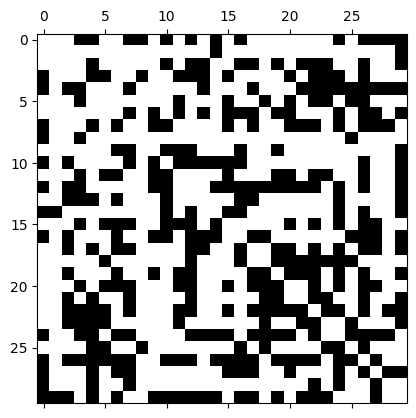

In [121]:
# G = nx.random_graphs.connected_watts_strogatz_graph(25, 4, 0.7)
n, v = (30,50)
B = nx.bipartite.random_graph(n, v, .1)
G=nx.bipartite.weighted_projected_graph(B, nodes=range(n))
# nx.set_edge_attributes(G, values = 1, name = 'weight')
nx.set_node_attributes(G, nx.pagerank(G), name='importance')
ef = sf.Frame.from_records_items(enumerate(G.edges))
ein = sf.SeriesHE.from_element(1, index=sf.IndexHierarchy.from_labels(ef[0].items()))
eou = sf.SeriesHE.from_element(1, index=sf.IndexHierarchy.from_labels(ef[1].items()))
s = sf.SeriesHE.from_concat((ein,eou))
Bin = sprs.coo_array((ein, (ein.index.values_at_depth(0), ein.index.values_at_depth(1))), shape=(ein.size, n)).toarray()
Bou = sprs.coo_array((eou, (eou.index.values_at_depth(0), eou.index.values_at_depth(1))), shape=(eou.size, n)).toarray()
plt.spy(Bou.T@Bin+Bin.T@Bou)

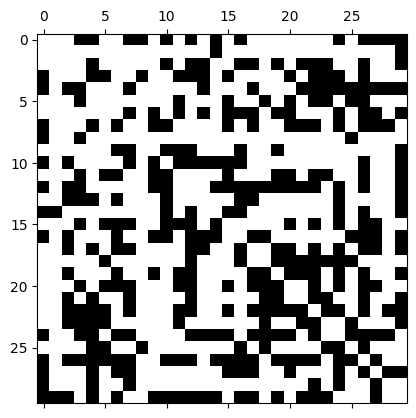

In [122]:
plt.spy(nx.to_numpy_array(G))

In [123]:
cts=sprs.csc_array(Bin+Bou)
cts=nx.bipartite.biadjacency_matrix(B, range(n)).T
def tf_idf(cts):
    idf=cts.sum(axis=0)
    df = cts.copy()
    df.data = 1./df.data
    N = cts.shape[0]
    
    return sprs.csc_array(np.multiply(idf,np.log(N*df.toarray())))
tfidf = tf_idf(cts)
cts, tfidf
# sprs.csc_array(cts/np.sqrt(cts.power(2).sum(axis=0)))
# sprs.csc_array.

/tmp/ipykernel_339377/740118381.py:2: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  cts=nx.bipartite.biadjacency_matrix(B, range(n)).T
/tmp/ipykernel_339377/740118381.py:9: RuntimeWarning: divide by zero encountered in log
  return sprs.csc_array(np.multiply(idf,np.log(N*df.toarray())))


(<50x30 sparse matrix of type '<class 'numpy.int64'>'
 	with 153 stored elements in Compressed Sparse Column format>,
 <50x30 sparse array of type '<class 'numpy.float64'>'
 	with 1500 stored elements in Compressed Sparse Column format>)

In [124]:
adata = ad.AnnData(
    X=cts, 
    layers={
        'tfidf':tfidf,
    },
    # oidx=range(len(newsgroups_train.data)),
    # vidx=cts_model.get_feature_names_out(),
    
    dtype=np.int64,
    # varp = {'proj':},
    
)
from scipy.spatial.distance import cosine, pdist, squareform
def sparse_cosine_similarity(sparse_matrix):
    # out = (sparse_matrix.copy() if type(sparse_matrix) is sprs.csr_matrix else
    #        sparse_matrix.tocsr())
    out = sprs.csc_matrix(sparse_matrix, dtype=np.float64)
    squared = out.multiply(out)
    sqrt_sum_squared_rows = np.array(np.sqrt(squared.sum(axis=1)))[:, 0]
    row_indices, col_indices = out.nonzero()
    out.data /= sqrt_sum_squared_rows[row_indices]
    return out.dot(out.T)

# def sparse_cosine_similarity(sparse_matrix):
#     input_csr_matrix = sprs.csc_matrix(sparse_matrix)
#     similarity = input_csr_matrix * input_csr_matrix.T
#     square_mag = similarity.diagonal()
#     inv_square_mag = 1 / square_mag
#     inv_square_mag[np.isinf(inv_square_mag)] = 0
#     inv_mag = np.sqrt(inv_square_mag)
#     return similarity.multiply(inv_mag).T.multiply(inv_mag)


def cosine_similarity(X):
    norm = sprs.csc_array(X/np.sqrt(X.multiply(X).sum(axis=0)))
#     cos = X.T.dot(X)/(onp.sqrt((X**2).sum()))
    cos = norm.T.dot(norm)
    return cos - sprs.diags(cos.diagonal())  # valid adjacency


def project_ADL(B, filt=10, cos=True):
    proj = cosine_similarity(B) if cos else B.T.dot(B)
    # proj = sprs.csc_array(squareform(1 - pdist(B., metric='cosine')))
    
        
    # proj.data = np.where(proj.data < filt, 0, proj.data)
    d = sprs.diags(proj.diagonal())
    a = proj-d
    return a, d, d - a

# A,D,L = project_ADL(adata.X, cos=False)
adata.varp['A'], adata.varp['D'], adata.varp['L'] = project_ADL(adata.X, cos=False)
adata.varp['invL'] = pinvh(adata.varp['L'].toarray())

<AxesSubplot: >

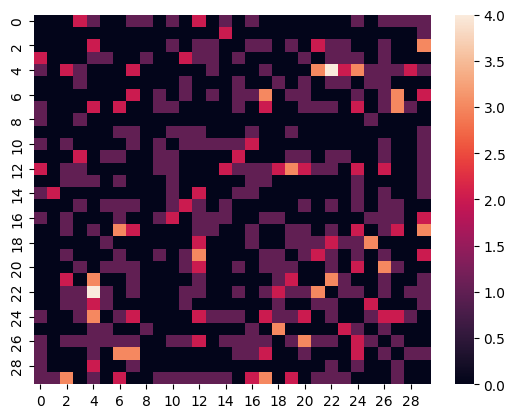

In [125]:
sns.heatmap(adata.varp['A'].toarray())
# sns.heatmap(cosine_similarity(adata.X).toarray())

<AxesSubplot: >

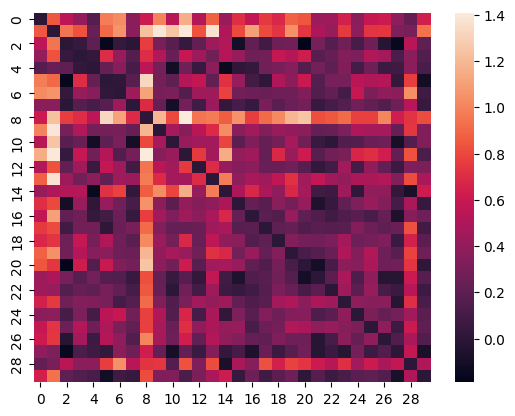

In [126]:
def commute_time(L_inv):
    diag = L_inv.diagonal()
    ii, jj = np.meshgrid(diag, diag)
    return ii+jj - 2*L_inv

sns.heatmap(
    commute_time(adata.varp['invL'])
    # adata.varp['invL']
)



<AxesSubplot: ylabel='Count'>

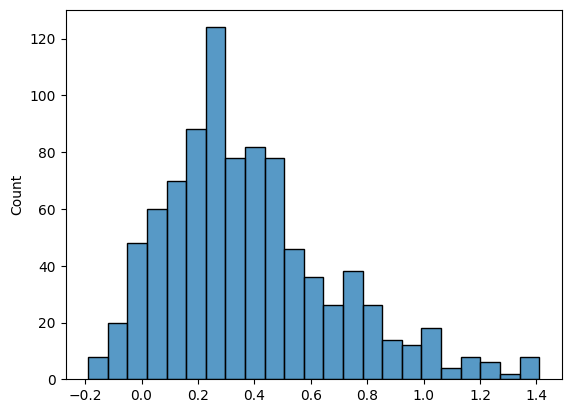

In [127]:
sns.histplot(commute_time(adata.varp['invL']).flatten())

<AxesSubplot: ylabel='Count'>

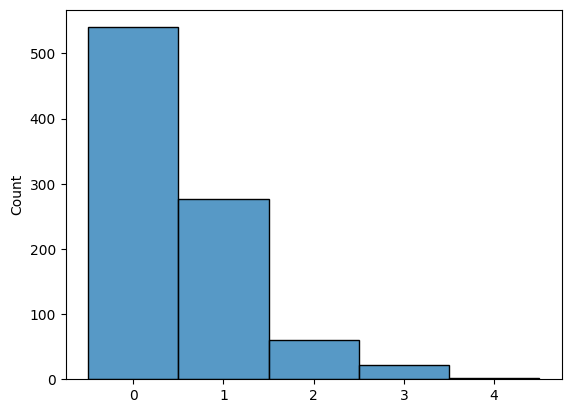

In [128]:
# print(newsgroups_train.target_names)
# adata.varp['A'].sum(axis=1).asarray()
sns.histplot(adata.varp['A'].toarray().flatten(), discrete=True)


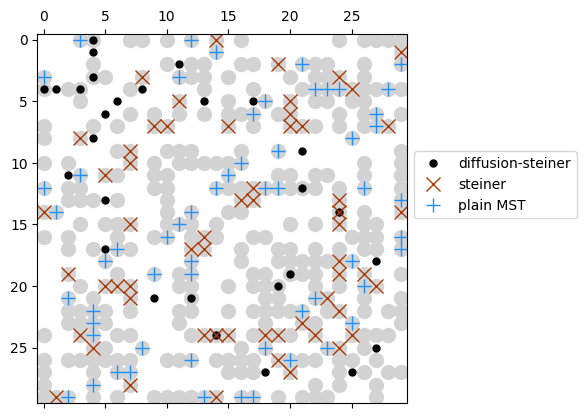

In [129]:
# df = pd.DataFrame.sparse.from_spmatrix(data=X, columns=list(cts.vocabulary_.keys()))
# df.sum(axis='index').sort_values()
def invert_elems(a, simplex=False):
    inv = a.copy()
    inv.data = 1-inv.data if simplex else 1./inv.data
    return inv
T = minimum_spanning_tree(commute_time(adata.varp['invL']))

STN = minimum_spanning_tree(sprs.csgraph.shortest_path(adata.varp['A']))
MST = minimum_spanning_tree(invert_elems(adata.varp['A']))
# MST = minimum_spanning_tree(invert_elems(cosine_similarity(cts), simplex=True))
# cos= cosine

# T2 = minimum_spanning_tree(1-)
plt.spy(adata.varp['A'], marker='o', color='lightgrey')
plt.spy(np.maximum(T.toarray(),T.T.toarray()), 
        marker='.', color='k', label='diffusion-steiner')
plt.spy(np.maximum(STN.toarray(),STN.T.toarray()), 
        marker='x', color='xkcd:rust', label='steiner')
plt.spy(np.maximum(MST.toarray(), MST.T.toarray()), 
        marker='+', color='dodgerblue', label='plain MST')
plt.legend(bbox_to_anchor=(1,.7))
# sprs.csgraph.shortest_path(

In [120]:
T.toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.36494205, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

<11314x11314 sparse matrix of type '<class 'numpy.float64'>'
	with 128006596 stored elements in Compressed Sparse Column format>

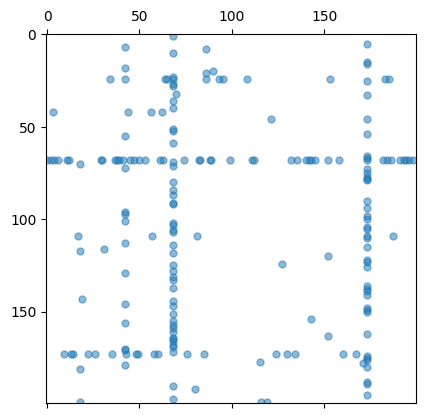

In [221]:
plt.spy(T, marker='.', alpha=.50)
# plt.spy(T2, marker='.', alpha=.50, color='r')
T2
# squareform(pdist(adata.X.toarray(), 'cosine'))



In [208]:
T.nonzero()

(array([  1,   5,   7,   8,  10,  15,  16,  18,  20,  21,  23,  24,  24,
         24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  25,  27,  28,
         32,  33,  36,  40,  42,  42,  42,  42,  46,  46,  51,  52,  54,
         55,  59,  66,  67,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,  68,
         68,  68,  68,  68,  68,  68,  68,  68,  69,  70,  71,  72,  73,
         75,  77,  78,  79,  80,  84,  87,  90,  91,  92,  94,  96,  97,
         98, 100, 101, 102, 103, 104, 105, 106, 107, 109, 109, 109, 109,
        109, 110, 113, 114, 115, 116, 117, 118, 120, 122, 123, 124, 125,
        126, 128, 129, 131, 133, 136, 137, 138, 139, 141, 143, 144, 146,
        147, 148, 149, 150, 151, 154, 155, 156, 157, 159, 161, 162, 163,
        164, 165, 166, 168, 169, 170, 171, 172, 173, 173, 173, 173, 173,
        173, 173, 173, 173, 173, 173, 173, 173, 173

In [96]:
from scipy.sparse.linalg import eigsh

# pca = PCA().fit_transform(np.asarray(adj))
sig, u = eigsh(adj.values, k=90)


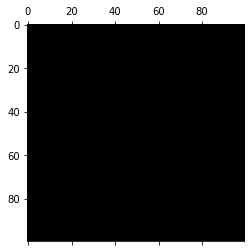

In [99]:
adj_filt = u@np.diag(sig/(1+sig))@u.T
plt.spy(adj_filt)

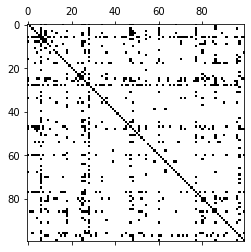

In [98]:
plt.spy(np.where(adj_filt>1e-2, adj_filt, 0))

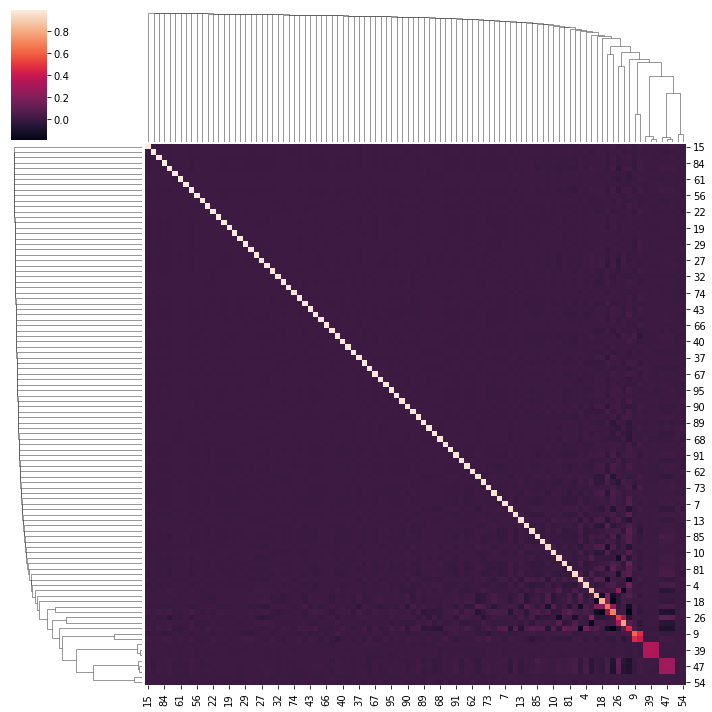

In [104]:
import seaborn as sns

# sns.clustermap(np.where(adj_filt>1e-2, adj_filt, 0))
sns.clustermap(adj_filt)

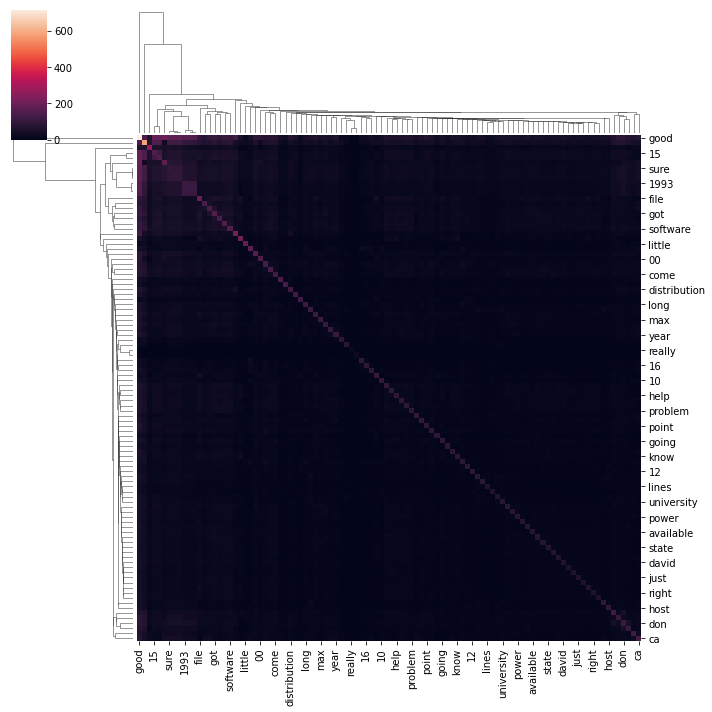

In [103]:
sns.clustermap(adj)